In [1]:
import os
os.chdir('../')

In [2]:
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax
try:
    import flax
except ModuleNotFoundError:
    %pip install -qq flax
    import flax
try:
    import jaxopt
except ModuleNotFoundError:
    %pip install -qq jaxopt
    import jaxopt
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import jit
import flax.linen as nn
from flax.training import train_state
import tensorflow_probability.substrates.jax as tfp
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf
import seaborn as sns
from models import mlp, gmlp
from datasets import regression_data_bootstrap
from utility import utils

2022-06-28 21:53:59.476200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


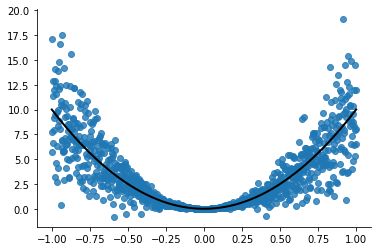

In [3]:
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X,Y,y_true = regression_data_bootstrap.data_hetero(points=1000, xrange=(-3,3), std=4) 
plt.figure() 
plt.scatter(X, Y,alpha=0.8)
plt.plot(X ,y_true, linewidth=2,color='black',linestyle='-')
sns.despine()

In [4]:
model = gmlp.gmlp([16,16])

In [5]:
n_estimators = 10
x_grid = jnp.linspace(-2,2,1000).reshape(-1,1)
keys = jax.random.split(jax.random.PRNGKey(0),n_estimators)
Y_final = []
parameters=[]
for i in range(n_estimators):
  ids = jax.random.choice(keys[i], jnp.array(range(1000)), (1000,1))
  x, y = X[ids].reshape(-1,1), Y[ids].reshape(-1,1)
  loss = []
  params = model.init(keys[i], x)
  params,losses = utils.fit(model, params, x, y, epochs=100)
  Y_pred = model.apply(params, x_grid)
  parameters.append(params)
  Y_final.append(Y_pred)

In [6]:
Y_final = jnp.array(Y_final)
Y_final = jnp.transpose(Y_final,(0,2,1))
means_ = Y_final[:,:,0]
sigmas_ = Y_final[:,:,1]
mean = means_.mean(axis=0)
sigma = (sigmas_ + means_**2).mean(axis=0) - mean**2

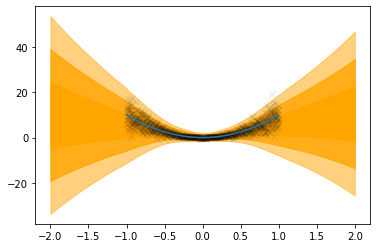

In [7]:
plt.plot(X,Y,'kx',alpha=0.1)
plt.fill_between(x_grid.squeeze(),mean+sigma,mean-sigma,color='orange',alpha=1)
plt.fill_between(x_grid.squeeze(),mean+2*sigma,mean-2*sigma,color='orange',alpha=0.8)
plt.fill_between(x_grid.squeeze(),mean+3*sigma,mean-3*sigma,color='orange',alpha=0.5)
plt.plot(X,10*X*X)

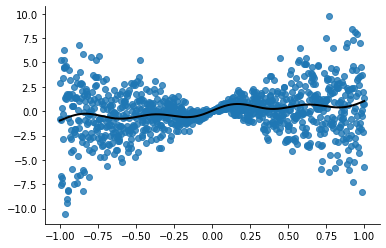

In [8]:
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X,Y,y_true = regression_data_bootstrap.data_sin(points=1000, xrange=(-3,3), std=4) 
plt.figure() 
plt.scatter(X, Y,alpha=0.8)
plt.plot(X ,y_true, linewidth=2,color='black',linestyle='-')
sns.despine()

In [9]:
model = gmlp.gmlp([16,16])

In [10]:
n_estimators = 10
x_grid = jnp.linspace(-2,2,1000).reshape(-1,1)
keys = jax.random.split(jax.random.PRNGKey(0),n_estimators)
Y_final = []
parameters=[]
for i in range(n_estimators):
  ids = jax.random.choice(keys[i], jnp.array(range(1000)), (1000,1))
  x, y = X[ids].reshape(-1,1), Y[ids].reshape(-1,1)
  loss = []
  params = model.init(keys[i], x)
  params,losses = utils.fit(model, params, x, y, epochs=100)
  Y_pred = model.apply(params, x_grid)
  parameters.append(params)
  Y_final.append(Y_pred)

In [11]:
Y_final = jnp.array(Y_final)
Y_final = jnp.transpose(Y_final,(0,2,1))
means_ = Y_final[:,:,0]
sigmas_ = Y_final[:,:,1]
mean = means_.mean(axis=0)
sigma = (sigmas_ + means_**2).mean(axis=0) - mean**2

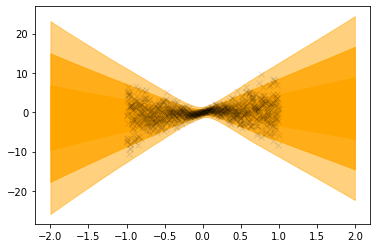

In [12]:
plt.plot(X,Y,'kx',alpha=0.1)
plt.fill_between(x_grid.squeeze(),mean+sigma,mean-sigma,color='orange',alpha=1)
plt.fill_between(x_grid.squeeze(),mean+2*sigma,mean-2*sigma,color='orange',alpha=0.8)
plt.fill_between(x_grid.squeeze(),mean+3*sigma,mean-3*sigma,color='orange',alpha=0.5)